
# Convolution Neural Network

## Importing Libraries

In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt
import cv2
import math
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
import time
from tqdm.notebook import tnrange
import threading

## Train data

In [3]:
loc = 'D:/CNN_1.0/Dataset_50_4.obj'

In [4]:
f = open(loc , 'rb')
X_train , Y_train , Labels = pickle.load(f)
print(f"""X_train shape : {X_train.shape}, Y_train shape : {Y_train.shape}""")

_ , X_test , _ , Y_test = train_test_split(X_train, Y_train, 
                                                    test_size=0.33,
                                                    shuffle=True,
                                                    random_state=42)

print(f"""X_train shape : {X_train.shape}, Y_train shape : {Y_train.shape}
X_test shape : {X_test.shape}, Y_test shape : {Y_test.shape}""")

X_train shape : (13320, 50, 50, 3), Y_train shape : (13320,)
X_train shape : (13320, 50, 50, 3), Y_train shape : (13320,)
X_test shape : (4396, 50, 50, 3), Y_test shape : (4396,)


In [5]:
fileName = 'model_50_6_New.h5'

In [6]:
def callback(obj,fileName) :
    print('CallBack : ',fileName,'Updated')
    f = open(fileName, 'wb') 
    pickle.dump(obj, f)

## Layers
---

## Activation Layers

In [8]:
class ReLU :
    def __init__ (self) :
        self.__type__ = 'activation'
        self.__Name__ = 'ReLU'
    
    def feed(self,X) :
        self.input = X
        self.input_shape=X.shape
        self.output = np.maximum(0,X)
        self.output_shape = self.input_shape
        return self.output
    
    def feed_back(self,grad_output,lr) :
        grad = self.input > 0
        return grad_output*grad
    
class TanH :
    def __init__(self) :
        self.__type__ = 'activation'
        self.__Name__ = 'TanH'
    def feed(self,X) :
        self.input = X
        self.output = np.tanh(X)
        return self.output
        
    def feed_back(self,grad_output,lr) :
        out = 1-np.power(np.tanh(self.input),2)
        return out
    
    def predict(self,Y) :
        output = np.tanh(Y)
        return output
    
class Softmax :
    def __init__ (self) :
        self.__type__ = 'activation'
        self.__Name__ = 'Softmax'
    
    def feed(self,X) :
        self.input = X
        e_x = np.exp(X-np.max(X))
        self.output = e_x/e_x.sum()
        return self.output
    
    def feed_back(self,grad_output,lr) :
        X = self.input
        e_x = np.exp(X-np.max(X))
        grad = e_x/e_x.sum()**2 - (e_x**2/(e_x.sum()**2))
        #print(grad)
        return grad_output*grad
    
class Sigmoid :
    def __init__ (self) :
        self.__type__ = 'activation'
        self.__Name__ = 'Sigmoid'
    
    def feed(self,X) :
        self.input = X
        self.output = 1/(1+np.exp(-X))
        return self.output
    
    def feed_back(self,grad_output,lr) :
        grad = self.output*((1-self.output)**2)
        return grad_output*grad

### Convolutional Layer

In [9]:
class Conv2D :
    
    def __init__ (self,N_F,K_S,input_shape,A_F=None,STRIDES=1,pad=0) :
        self.__Name__ = 'Conv2D'
        self.__type__ = 'conv'
        self.N_F = N_F
        self.K_S = K_S
        self.STRIDES = STRIDES
        self.A_F = A_F
        self.pad = pad
        if (len(input_shape) == 2) :
            input_shape = input_shape+(1,)
        if input_shape[0] is not None :
            self.input_shape = (None,) + input_shape
        else :
            self.input_shape = input_shape
        #self.weights = np.random.normal(size=(self.N_F,self.input_shape[-1],self.K_S,self.K_S))
        self.weights = np.random.randint(-1,2,(self.N_F,self.input_shape[-1],self.K_S,self.K_S))
        self.W = int((self.input_shape[1]-self.K_S+2*self.pad)/self.STRIDES) + 1
        self.H = int((self.input_shape[2]-self.K_S+2*self.pad)/self.STRIDES) + 1
        self.D = self.N_F
        self.bias = np.zeros((self.N_F))
        self.output_shape = (None,) + (self.W,self.H,self.D)
        self.Batch_W = []
        self.Batch_B = []
        self.mdw = np.zeros((self.input_shape[1], self.output_shape[1])) 
        self.mdb = np.zeros((1,self.output_shape[1]))
        
        self.vdw = np.zeros((self.input_shape[1], self.output_shape[1])) 
        self.vdb = np.zeros((1,self.output_shape[1]))
        
    def feed(self,X) :
        outputs = []
        for x in X :
            if self.pad >0 :
                x_ = np.zeros((x.shape[0]+self.pad*2,x.shape[1]+self.pad*2,x.shape[2]))
                x_[self.pad:-self.pad,self.pad:-self.pad] = x
                x = x_
            output = np.zeros((self.W,self.H,self.D))
            h = 0
            for i in range(0,self.input_shape[1],self.STRIDES) :
                w = 0
                for j in range(0,self.input_shape[2],self.STRIDES) :
                    cur_reg = x[i:i+self.K_S,j:j+self.K_S].T*self.weights
                    output[h,w] = np.sum(cur_reg,axis=(1,2,3)) + self.bias
                    w += 1
                h += 1
            outputs.append(output)
        return np.array(outputs)
    
    def feed_back(self, Z , output_error, learning_rate=[1e-02],decay=1e-03,opt='sgd',b1=.9,b2=.999) :
        outs = []
        return np.array(outs)

    def predict(self,Y) :
        output = np.zeros((self.W,self.H,self.D))
        h = 0
        if self.pad >0 :
            x_ = np.zeros(((Y.shape[0]+self.pad*2),Y.shape[1]+self.pad*2,Y.shape[2]))
            x_[self.pad:-self.pad,self.pad:-self.pad] = Y
            Y = x_
        for i in range(0,self.input_shape[1],self.STRIDES) :
            w = 0
            for j in range(0,self.input_shape[2],self.STRIDES) :
                cur_reg = Y[i:i+self.K_S,j:j+self.K_S].T*self.weights
                output[h,w] = np.sum(cur_reg,axis=(1,2,3)) + self.bias
                w += 1
            h += 1
        return output
    
    def plotImg(self,X=None,figSize=(5,5)) :
        if X is None :
            return
        for x in X :
            Filter_SIZE = int(x.shape[-1]**(1/2))
            _, axs = plt.subplots(Filter_SIZE,Filter_SIZE, figsize=figSize)
            axs = axs.flatten()
            for i , ax in enumerate(axs) :
                img = x[:,:,i]
                ax.axis('off')
                ax.imshow(img)
            plt.show()
        
    def Summary(self) :
        l = len(self.__Name__)
        print(f'{self.__Name__}',' '*(20-l),self.input_shape,' '*(20-len(str(self.input_shape))),self.output_shape)

### Pool Layer

In [10]:
class MaxPool2D :
    
    def __init__ (self,K_S,input_shape,STRIDES=2,pad=0) :
        self.__Name__ = 'MaxPool2D'
        self.__type__ = 'pool'
        self.K_S = K_S
        self.STRIDES = STRIDES
        self.A_F = None
        self.pad = pad
        self.input_shape = input_shape
        self.output_shape = (None,) + (int((self.input_shape[1]-self.K_S+1)/self.STRIDES),int((self.input_shape[2]-self.K_S+1)/self.STRIDES),self.input_shape[-1])
        self.Batch_W = []
        self.Batch_B = []
        self.weights = np.zeros((self.input_shape[1:]))
        self.bias = np.zeros((self.output_shape[1:]))
    
    def feed(self,X) :
        outputs = []
        for x in X :
            if self.pad >0 :
                x_ = np.zeros(((x.shape[0]+self.pad*2),x.shape[1]+self.pad*2,x.shape[2]))
                x_[self.pad:-self.pad,self.pad:-self.pad] = x
                x = x_
            W,H,D = self.output_shape[1:]
            output = np.zeros((W,H,D))
            w , h = 0 , 0
            for j in range(0,self.input_shape[1]-self.K_S,self.STRIDES) :
                for i in range(0,self.input_shape[2]-self.K_S,self.STRIDES) :
                    output[w,h] = np.max(x[j:j+self.K_S,i:i+self.K_S].T,axis=(1,2))
                    h += 1
                h = 0
                w += 1
            outputs.append(output)
        return np.array(outputs)
    
    def create_mask_from_window(self,x):
        mask = x == np.max(x)
        return mask
    
    def feed_back(self, Z , output_error, learning_rate=[1e-03],decay=1e-03,opt='sgd') :
        outs = []
#         _,W,H,C = output_error.shape
#         for z,out_err in zip(Z,output_error) :
#             d_op = np.zeros(z.shape)
#             for x in range(0,W) :
#                 for y in range(0,H) :
#                     for c in range(C) :
#                         roi = z[x:x+self.K_S,y:y+self.K_S,c]
#                         mask = self.create_mask_from_window(roi)
#                         #update_y ,update_x = np.unravel_index(np.argmax(roi),roi.shape)
#                         d_op[x:x+self.K_S,y:y+self.K_S,c] = np.multiply(mask, out_err[x,y,c]) #output_error[out_y,out_x]
#             outs.append(d_op)
        return np.array(outs)
    
    def predict(self,Y) :
        W,H,D = self.output_shape[1:]
        output = np.zeros((W,H,D))
        w , h = 0 , 0
        for i in range(0,self.input_shape[1]-self.K_S,self.STRIDES) :
            for j in range(0,self.input_shape[2]-self.K_S,self.STRIDES) :
                output[w,h] = np.max(Y[j:j+self.K_S,i:i+self.K_S].T,axis=(1,2))
                h += 1
            h = 0
            w += 1
        return output
    
    def plotImg(self,X=None) :
        if X is None :
            return
        for x in X :
            Filter_SIZE = int(x.shape[-1]**(1/2))
            _, axs = plt.subplots(Filter_SIZE,Filter_SIZE, figsize=(8,8))
            axs = axs.flatten()
            for i , ax in enumerate(axs) :
                img = x[:,:,i]
                ax.axis('off')
                ax.imshow(img)
            plt.show()
        
    def Summary(self) :
        l = len(self.__Name__)
        print(f'{self.__Name__}',' '*(20-l),self.input_shape,' '*(20-len(str(self.input_shape))),self.output_shape)

### Flatten Layer

In [11]:
class Flatten :
    
    def __init__ (self,input_shape=None) :
        self.__Name__ = 'Flatten'
        self.__type__ = 'flat'
        self.input_shape = input_shape
        self.A_F = None
        re = 1
        for i in input_shape :
            re *= i
        self.output_shape = re
        
    def feed(self,X) :
        self.input = X
        self.output = X.ravel()
        return self.output
    
    def Summary(self) :
        l = len(self.__Name__)
        print(f'{self.__Name__}',' '*(20-l),self.input_shape,' '*(20-len(str(self.input_shape))),self.output_shape)

### Dropout Layer

In [12]:
class Dropout :
    def __init__(self,input_shape=None,drop=.5,__Name__ = 'Dropout',A_F=None) :
        self.__Name__ = __Name__
        self.__type__ = 'drop'
        self.N_F = drop
        self.input_shape = input_shape
        self.output_shape = self.input_shape
        self.weights = np.random.binomial(1, drop, self.input_shape) / drop
        self.A_F = A_F
        self.Batch_W = []
        
    def feed(self,X) :
#         outputs = []
        return X*self.weights.T
#         return np.array(outputs)
    
    def feed_back(self, Z , output_error, learning_rate=[1e-03],decay=1e-03,opt='sgd') :
        return output_error * Z / self.N_F
    
    def predict(self,Y) :
        return Y*self.weights
    
    def Summary(self) :
        l = len(self.__Name__)
        print(f'{self.__Name__}',' '*(20-l),self.input_shape,' '*(20-len(str(self.input_shape))),self.output_shape)

### Dense Layer

In [13]:
class Dense :
    
    def __init__ (self,input_shape,N_F) :
        self.__Name__ = 'Dense'
        self.__type__ = 'dense'
        self.input_shape = input_shape
        self.N_F = N_F
        #self.A_F = A_F
        self.output_shape = N_F
        self.weights = 0.1*np.random.randn(self.input_shape, self.output_shape) / np.sqrt(self.input_shape + self.output_shape)
        self.bias = np.random.randn(1, self.output_shape) / np.sqrt(self.input_shape + self.output_shape)
        
    def feed(self,X) :
        if X.shape[0] != 1 :
            output = []
            output.append(X)
            self.input = np.array(output)
        else :
            self.input = X
#         for x in X :
#             self.input = x
        self.output = np.dot(X,self.weights) + self.bias
        return self.output
    
    def feed_back(self, output_error, learning_rate=[1e-03]):
        lr = learning_rate[np.random.randint(len(learning_rate))]
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        self.weights -= lr * weights_error# / np.sqrt(self.input_shape + self.output_shape)
        self.bias -= lr * output_error #/ np.sqrt(self.input_shape + self.output_shape)
        return input_error
    
    def Summary(self) :
        l = len(self.__Name__)
        print(f'{self.__Name__}',' '*(20-l),self.input_shape,' '*(20-len(str(self.input_shape))),self.output_shape)

In [14]:
class Sequential :
    
    def __init__ (self) :
        self.Layers = []
        self.input_shape = None
        self.activations = []
        
    def add(self,Layer) :
        self.Layers.append(Layer)
        if Layer.__type__ != 'activation' :
            if self.input_shape is None :
                self.input_shape = Layer.input_shape
            self.output_shape = Layer.output_shape
            #self.activations.append(Layer.A_F)
        
    def compile(self,loss='cross_entropy',metrics=['acc']) :
        self.loss = loss
        self.metrics = metrics
        
    def one_hot_encode(self,labels) :
        Labels = np.zeros((len(labels),len(set(labels))))
        for i,label in enumerate(labels) :
            Labels[i][label] = 1
        return Labels
        
    def fit(self,train_data,valid_data=None,validation_split=.1,epochs=10,lr=0.01,Labels=None) :
        self.acc = []
        self.val_acc = []
        self.error = []
        self.val_error = []
        self.epochs = epochs
        
        if Labels is not None :
            model.Labels = Labels
        
        input_data , output_data , val_input_data , val_output_data , Total = None , None , None , None , None
        
        if train_data is None :
            raise ValueError('Training Data Required')
        else :
            input_data = train_data[0]
            Total = train_data[1]
            output_data = Total
        N = len(input_data)
        
        if valid_data is None :
            if validation_split != 0 :
                n = int(len(input_data)*(1-validation_split))
                K = np.random.randint(0,N,(N))
                for i in range(N-1) :
                    train_data[0][K[i]] = train_data[0][K[i+1]]
                    train_data[1][K[i]] = train_data[1][K[i+1]]
                input_data , output_data = train_data[0][:n] , output_data[:n]
                val_input_data , val_output_data = train_data[0][n:] , output_data[n:]
        else :
            val_input_data , val_output_data = valid_data[0] , valid_data[1]
            
        #N = len(self.input)
        
        print('\nModel Fitting\n')
        error = 0
        for ep in tnrange(epochs,desc=f'epochs') :
            pre_error = 0
            ratio = 0
            val_ratio = 0
            N = len(input_data)
            for c in range(N) :
                output = input_data[c]
                Y = output_data[c]
                ### Forward Feeding
                for Layer in self.Layers :
                    output = Layer.feed(output)
                loss = 0
                out_err = 0
                
                if self.loss == 'cross_entropy' :
                    loss = self.crossentropy(output,Y)
                    out_err = self.grad_crossentropy(output,Y)
                elif self.loss == 'mean_squared_error' :
                    loss = self.mse(Y,output)
                    out_err = (Y-output)*self.transfer_derivative(output)
                    
                #print(loss,out_err,output)
                #print('->',output,np.sum(output))
                
                # Backward Feeding
                for Layer in reversed(self.Layers) :
                    #print('=>',out_err)
                    #if Layer.__Name__ != 'Softmax' :
                    if Layer.__Name__ != 'Flatten' :
                        out_err = Layer.feed_back(out_err,lr)
                    else :
                        break
                        
#                 error = np.mean(loss)
                
                print('\rerror=%f' % (loss),end="")
#             error = np.mean(loss)
            if (ep+1) % 1 == 0 :
                ratio = sum([y == np.argmax(self.predict(x)) for x, y in zip(input_data, output_data)]) / len(output_data)

                self.acc.append(ratio)

                if 'acc' in self.metrics :
                    val_ratio = sum([y == np.argmax(self.predict(x)) for x, y in zip(val_input_data,
                                                                                      val_output_data)]) / len(val_input_data)
                    self.val_acc.append(val_ratio)
                    print('\n\repoch %d/%d, error=%f , acc=%f , val_acc=%f' % (ep + 1, epochs, error, ratio , val_ratio))
                else :
                    print('\n\repoch %d/%d, error=%f , acc=%f' % (ep + 1, epochs , error , ratio))
                
        callback(self,fileName)
            
    def mse(self,y_true, y_pred):
        return np.mean(np.power(y_true - y_pred, 2))
    
    def mse_prime(self,y_true, y_pred):
        return 2 * (y_pred - y_true) / y_pred.size
    
    def transfer_derivative(self,output):
        return output * (1.0 - output)
    
    def crossentropy(self,logits,reference_answers):
        return - logits[0][reference_answers] + np.log(np.sum(np.exp(logits),axis=-1))
    
    def grad_crossentropy(self,logits,reference_answers):
        ones_for_answers = np.zeros_like(logits)
        ones_for_answers[np.arange(len(logits)),reference_answers] = 1
        softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
        return (- ones_for_answers + softmax) / logits.shape[0]
    
    def showImg(self,X) :
        plt.imshow(X)
        plt.show()
    
    def predict(self,X):
        soft = Softmax()
        if X.shape == self.input_shape :
            output = X
            for Layer in self.Layers :
                output = Layer.feed(output)
            return soft.feed(output)
        else :
            outputs = []
            for x in X :
                out = x
                for Layer in self.Layers :
                    out = Layer.feed(out)
                outputs.append(soft.feed(out))
            return np.array(outputs)
    
    def pred_class(self,X) :
        output = X
        for Layer in self.Layers :
            output = Layer.feed(output)
        return np.argmax(output)
    
    def Summary(self) :
        print('='*60)
        print('Model Summary')
        print('_'*60)
        print('Layers',' '*(20-len('Layers')),'Input Shape',' '*(20-len('Input Shape')),'Output Shape',' '*(20-len('Output Shape')))
        print('='*60)
        for Layer in self.Layers :
            if Layer.__type__ != 'activation' :
                Layer.Summary()
                print('_'*60)
        print('='*60)

In [15]:
model = Sequential()
# model.add(Conv2D(3,3,input_shape=X_train[0].shape,pad=2,STRIDES=2))
# model.add(ReLU())
# model.add(MaxPool2D(5,STRIDES=3,input_shape=model.output_shape))
# # model.add(Conv2D(8,3,input_shape=model.output_shape))
# # model.add(MaxPool2D(5,STRIDES=3,input_shape=model.output_shape))
# model.add(Flatten(input_shape=model.output_shape))
model.add(Flatten(input_shape=X_train[0].shape))
# model.add(Dense(input_shape=model.output_shape,N_F=100))
# model.add(TanH())
# model.add(Dense(input_shape=model.output_shape,N_F=100))
# model.add(ReLU())
#model.add(Dropout(input_shape=model.output_shape))
model.add(Dense(input_shape=model.output_shape,N_F=len(set(Y_train))))
# model.add(Softmax())
# model.add(Sigmoid())
model.compile(loss='cross_entropy',metrics=['acc'])

model.Summary()

Model Summary
____________________________________________________________
Layers                Input Shape           Output Shape         
Flatten               (50, 50, 3)           7500
____________________________________________________________
Dense                 7500                  6
____________________________________________________________


In [16]:
start = time.time()
model.fit(train_data=(X_train,Y_train),
          epochs=300,lr=[0.001],
          Labels=Labels,valid_data=(X_test,Y_test) )
print(f'Time Taken : {(time.time()-start)/60} Minutes.')


Model Fitting



error=0.0000674
epoch 1/300, error=0.000000 , acc=0.152014 , val_acc=0.150008
CallBack :  model_50_6_New.h5 Updated
error=0.0000714
epoch 2/300, error=0.000000 , acc=0.152014 , val_acc=0.150008
CallBack :  model_50_6_New.h5 Updated
error=0.0000820
epoch 3/300, error=0.000000 , acc=0.159362 , val_acc=0.157531
CallBack :  model_50_6_New.h5 Updated
error=0.0000964
epoch 4/300, error=0.000000 , acc=0.177097 , val_acc=0.173960
CallBack :  model_50_6_New.h5 Updated
error=0.0001128
epoch 5/300, error=0.000000 , acc=0.199088 , val_acc=0.195916
CallBack :  model_50_6_New.h5 Updated
error=0.0001308
epoch 6/300, error=0.000000 , acc=0.216164 , val_acc=0.212805
CallBack :  model_50_6_New.h5 Updated
error=0.0001474
epoch 7/300, error=0.000000 , acc=0.268001 , val_acc=0.261631
CallBack :  model_50_6_New.h5 Updated
error=0.0001645
epoch 8/300, error=0.000000 , acc=0.387687 , val_acc=0.383848
CallBack :  model_50_6_New.h5 Updated
error=0.000180
epoch 9/300, error=0.000000 , acc=0.428477 , val_acc=0.42

error=0.000389
epoch 72/300, error=0.000000 , acc=0.870889 , val_acc=0.869338
CallBack :  model_50_6_New.h5 Updated
error=0.000383
epoch 73/300, error=0.000000 , acc=0.871143 , val_acc=0.869492
CallBack :  model_50_6_New.h5 Updated
error=0.000377
epoch 74/300, error=0.000000 , acc=0.871599 , val_acc=0.869952
CallBack :  model_50_6_New.h5 Updated
error=0.000371
epoch 75/300, error=0.000000 , acc=0.871751 , val_acc=0.870106
CallBack :  model_50_6_New.h5 Updated
error=0.000365
epoch 76/300, error=0.000000 , acc=0.872105 , val_acc=0.870259
CallBack :  model_50_6_New.h5 Updated
error=0.000359
epoch 77/300, error=0.000000 , acc=0.872460 , val_acc=0.870874
CallBack :  model_50_6_New.h5 Updated
error=0.000353
epoch 78/300, error=0.000000 , acc=0.872865 , val_acc=0.871181
CallBack :  model_50_6_New.h5 Updated
error=0.000347
epoch 79/300, error=0.000000 , acc=0.873119 , val_acc=0.871181
CallBack :  model_50_6_New.h5 Updated
error=0.000341
epoch 80/300, error=0.000000 , acc=0.873727 , val_acc=0.8

error=0.000118
epoch 143/300, error=0.000000 , acc=0.918571 , val_acc=0.916014
CallBack :  model_50_6_New.h5 Updated
error=0.000116
epoch 144/300, error=0.000000 , acc=0.919483 , val_acc=0.916782
CallBack :  model_50_6_New.h5 Updated
error=0.000115
epoch 145/300, error=0.000000 , acc=0.920446 , val_acc=0.917550
CallBack :  model_50_6_New.h5 Updated
error=0.000113
epoch 146/300, error=0.000000 , acc=0.921054 , val_acc=0.918624
CallBack :  model_50_6_New.h5 Updated
error=0.000111
epoch 147/300, error=0.000000 , acc=0.922067 , val_acc=0.919699
CallBack :  model_50_6_New.h5 Updated
error=0.000110
epoch 148/300, error=0.000000 , acc=0.923131 , val_acc=0.920620
CallBack :  model_50_6_New.h5 Updated
error=0.000108
epoch 149/300, error=0.000000 , acc=0.923892 , val_acc=0.921542
CallBack :  model_50_6_New.h5 Updated
error=0.000107
epoch 150/300, error=0.000000 , acc=0.925310 , val_acc=0.923538
CallBack :  model_50_6_New.h5 Updated
error=0.000105
epoch 151/300, error=0.000000 , acc=0.926121 , va

error=0.000027
epoch 283/300, error=0.000000 , acc=0.994629 , val_acc=0.993551
CallBack :  model_50_6_New.h5 Updated
error=0.000027
epoch 284/300, error=0.000000 , acc=0.994882 , val_acc=0.993858
CallBack :  model_50_6_New.h5 Updated
error=0.000027
epoch 285/300, error=0.000000 , acc=0.995034 , val_acc=0.994012
CallBack :  model_50_6_New.h5 Updated
error=0.000026
epoch 286/300, error=0.000000 , acc=0.995034 , val_acc=0.994012
CallBack :  model_50_6_New.h5 Updated
error=0.000026
epoch 287/300, error=0.000000 , acc=0.995136 , val_acc=0.994012
CallBack :  model_50_6_New.h5 Updated
error=0.000026
epoch 288/300, error=0.000000 , acc=0.995288 , val_acc=0.994319
CallBack :  model_50_6_New.h5 Updated
error=0.000026
epoch 289/300, error=0.000000 , acc=0.995389 , val_acc=0.994626
CallBack :  model_50_6_New.h5 Updated
error=0.000026
epoch 290/300, error=0.000000 , acc=0.995440 , val_acc=0.994780
CallBack :  model_50_6_New.h5 Updated
error=0.000026
epoch 291/300, error=0.000000 , acc=0.995440 , va

In [20]:
model.fit(train_data=(X_train,Y_train),
          epochs=100,lr=[0.001],
          Labels=Labels,valid_data=(X_test,Y_test) )


Model Fitting



error=0.000024
epoch 1/100, error=0.000000 , acc=0.996605 , val_acc=0.996469
CallBack :  model_50_6_New.h5 Updated
error=0.000024
epoch 2/100, error=0.000000 , acc=0.996656 , val_acc=0.996469
CallBack :  model_50_6_New.h5 Updated
error=0.000023
epoch 3/100, error=0.000000 , acc=0.996656 , val_acc=0.996469
CallBack :  model_50_6_New.h5 Updated
error=0.000023
epoch 4/100, error=0.000000 , acc=0.996656 , val_acc=0.996469
CallBack :  model_50_6_New.h5 Updated
error=0.000023
epoch 5/100, error=0.000000 , acc=0.996706 , val_acc=0.996469
CallBack :  model_50_6_New.h5 Updated
error=0.000023
epoch 6/100, error=0.000000 , acc=0.996757 , val_acc=0.996469
CallBack :  model_50_6_New.h5 Updated
error=0.000023
epoch 7/100, error=0.000000 , acc=0.996757 , val_acc=0.996469
CallBack :  model_50_6_New.h5 Updated
error=0.000023
epoch 8/100, error=0.000000 , acc=0.996960 , val_acc=0.996622
CallBack :  model_50_6_New.h5 Updated
error=0.000022
epoch 9/100, error=0.000000 , acc=0.997010 , val_acc=0.996622
Cal

error=0.000015
epoch 72/100, error=0.000000 , acc=0.998885 , val_acc=0.998925
CallBack :  model_50_6_New.h5 Updated
error=0.000015
epoch 73/100, error=0.000000 , acc=0.998885 , val_acc=0.998925
CallBack :  model_50_6_New.h5 Updated
error=0.000015
epoch 74/100, error=0.000000 , acc=0.998885 , val_acc=0.998925
CallBack :  model_50_6_New.h5 Updated
error=0.000015
epoch 75/100, error=0.000000 , acc=0.998987 , val_acc=0.998925
CallBack :  model_50_6_New.h5 Updated
error=0.000015
epoch 76/100, error=0.000000 , acc=0.998987 , val_acc=0.998925
CallBack :  model_50_6_New.h5 Updated
error=0.000015
epoch 77/100, error=0.000000 , acc=0.998987 , val_acc=0.998925
CallBack :  model_50_6_New.h5 Updated
error=0.000014
epoch 78/100, error=0.000000 , acc=0.998987 , val_acc=0.998925
CallBack :  model_50_6_New.h5 Updated
error=0.000014
epoch 79/100, error=0.000000 , acc=0.998987 , val_acc=0.998925
CallBack :  model_50_6_New.h5 Updated
error=0.000014
epoch 80/100, error=0.000000 , acc=0.998987 , val_acc=0.9

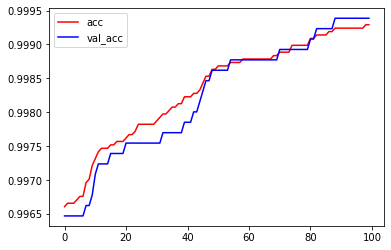

In [21]:
plt.plot(range(len(model.acc)),model.acc,c='r',label='acc')
plt.plot(range(len(model.val_acc)),model.val_acc,c='b',label='val_acc')
plt.legend()
plt.show()

In [22]:
print(f'Time Taken : {(time.time()-start)/60} Minutes.')

Time Taken : 323.48603974580766 Minutes.


---

## Testing purpose

### Predicting

[[2.51863201e-08 4.78339576e-16 2.92329715e-15 1.36927284e-18
  1.01651435e-10 9.99999975e-01]]


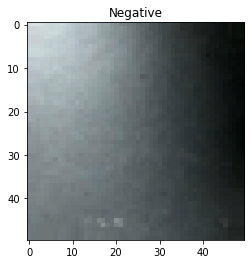

[[2.93896554e-06 1.49845008e-07 3.96503454e-08 1.19664875e-08
  5.34556329e-08 9.99996806e-01]]


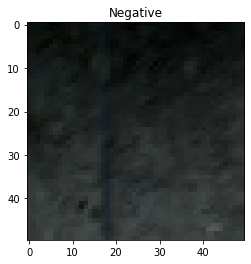

[[4.37650177e-12 2.05387217e-13 1.20310158e-10 4.67449556e-15
  8.16567162e-14 1.00000000e+00]]


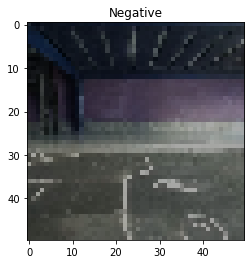

[[1.31678630e-17 9.25156882e-25 1.08972381e-21 2.09206314e-28
  2.82605057e-22 1.00000000e+00]]


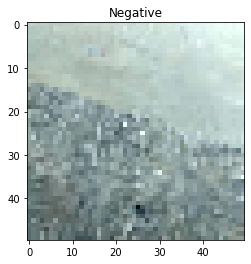

[[9.82639598e-01 1.68366342e-02 3.58911081e-04 9.61823725e-06
  8.19049342e-05 7.33333544e-05]]


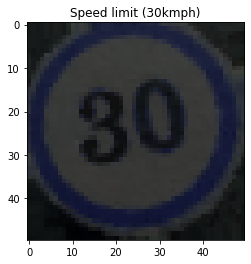

[[9.99816243e-01 1.83756628e-04 1.27260642e-10 6.33892812e-12
  1.24786920e-10 4.15559218e-12]]


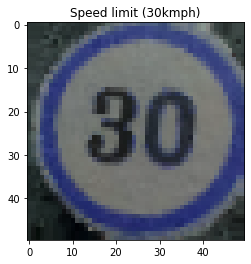

[[1.00000000e+00 5.25746972e-11 1.81866587e-16 2.95638809e-22
  7.67574190e-20 9.60065020e-18]]


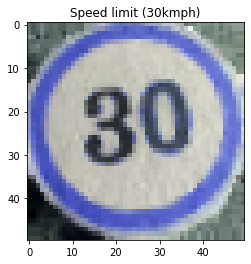

[[4.39871380e-09 9.99999996e-01 1.26976296e-13 2.58693688e-13
  2.80987041e-11 1.28133564e-14]]


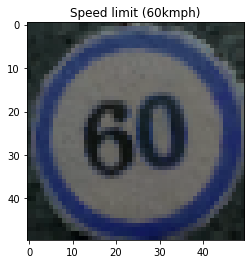

[[1.32805068e-13 1.00000000e+00 1.40263969e-18 5.05467671e-18
  1.01180689e-14 3.04618341e-19]]


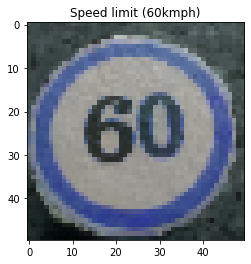

[[9.58236995e-15 1.00000000e+00 1.15153152e-23 4.20880131e-26
  1.49937321e-19 8.25989820e-26]]


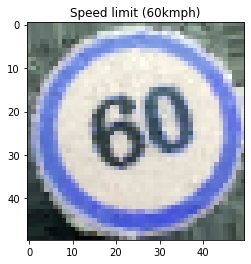

[[2.03273803e-15 1.00000000e+00 1.18445143e-23 8.15905863e-22
  3.53509361e-19 6.27263649e-22]]


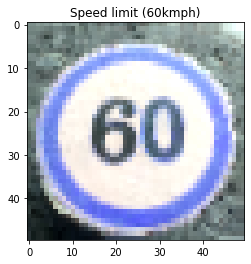

[[4.42987808e-12 3.06778570e-15 9.99999941e-01 6.31449466e-09
  5.30666106e-08 1.24214567e-12]]


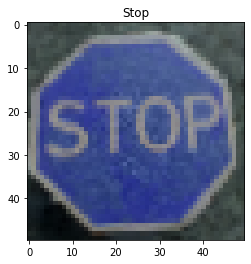

[[1.09332163e-06 1.01682000e-14 9.99995024e-01 2.40910820e-08
  3.85679469e-06 2.04536269e-09]]


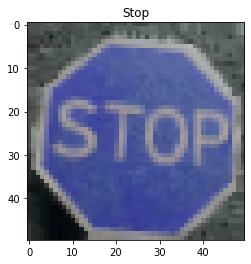

[[1.82609405e-08 4.78650070e-14 9.99993995e-01 4.76804562e-06
  1.49564743e-07 1.06921522e-06]]


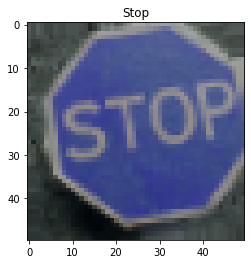

[[8.93628852e-25 4.59155848e-21 7.14968899e-18 4.83611598e-16
  1.00000000e+00 7.22049531e-22]]


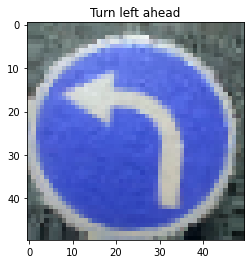

[[1.41673883e-10 6.21115378e-07 2.54961916e-07 9.60696044e-07
  9.99998154e-01 9.29945497e-09]]


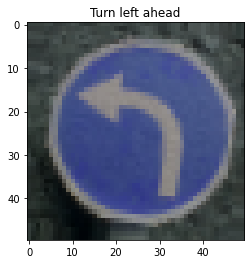

[[8.54344568e-16 3.64250093e-21 7.89916172e-13 7.40431565e-13
  1.00000000e+00 2.14983073e-20]]


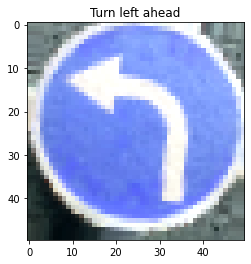

[[1.37382017e-12 4.31736255e-17 3.74396266e-08 9.99999960e-01
  2.88126484e-09 2.79988218e-14]]


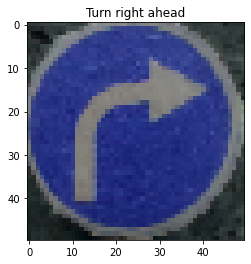

[[3.58606981e-16 1.16521274e-18 1.22548562e-11 1.00000000e+00
  9.82947694e-12 4.65827782e-19]]


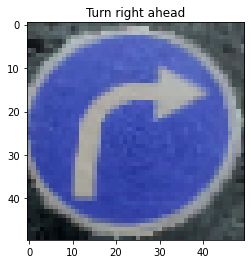

[[3.17187215e-07 4.04689530e-19 1.70056685e-08 9.99999661e-01
  3.39841083e-11 4.89034065e-09]]


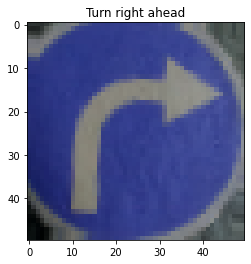

IndexError: index 20000 is out of bounds for axis 0 with size 19735

In [23]:
for cc in range(0,50000,1000) :
    print(model.predict(X_train[cc]))
    cla = model.pred_class(X_train[cc])
    plt.title(Labels[cla])
    plt.imshow(X_train[cc])
    plt.show()
    #print()

In [26]:
pred_Classes = {}
for i in range(len(Labels)) :
    pred_Classes[i] = {'tot':0,'correct' : 0 , 'wrong' : 0 , 'False' : 0 , 'acc' : 0}

In [27]:
for i,j in zip(X_train , Y_train) :
    pred_Classes[j]['tot'] += 1
    pred = np.argmax(model.predict(i).ravel())
    if pred == j :
        pred_Classes[j]['correct'] += 1
    else :
        pred_Classes[j]['wrong'] += 1
        pred_Classes[pred]['False'] += 1
    pred_Classes[j]['acc'] = pred_Classes[j]['correct'] * 100 / pred_Classes[j]['tot']
    print(f'\r {j} - {pred_Classes[j]}\t',end="")

 5 - {'tot': 206, 'correct': 206, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 5 - {'tot': 445, 'correct': 445, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 5 - {'tot': 673, 'correct': 673, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 5 - {'tot': 903, 'correct': 903, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 5 - {'tot': 1130, 'correct': 1130, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 5 - {'tot': 1328, 'correct': 1328, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 5 - {'tot': 1547, 'correct': 1547, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 5 - {'tot': 1754, 'correct': 1754, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 5 - {'tot': 1992, 'correct': 1992, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 5 - {'tot': 2212, 'correct': 2212, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 5 - {'tot': 2435, 'correct': 2435, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 5 - {'tot': 2636, 'correct': 2636, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 5 - {'tot': 2856, 'correct': 2856, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 5 - {'tot': 3086, 'correct': 3086, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 5 - {'tot': 3306, 'correct': 3306, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 5 - {'tot': 3543, 'correct': 3543, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 5 - {'tot': 3764, 'correct': 3764, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 0 - {'tot': 82, 'correct': 82, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 0 - {'tot': 291, 'correct': 291, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 0 - {'tot': 467, 'correct': 467, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 0 - {'tot': 686, 'correct': 686, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 0 - {'tot': 903, 'correct': 903, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 0 - {'tot': 1118, 'correct': 1118, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 0 - {'tot': 1341, 'correct': 1341, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 0 - {'tot': 1564, 'correct': 1564, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 0 - {'tot': 1789, 'correct': 1789, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 0 - {'tot': 2020, 'correct': 2020, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 0 - {'tot': 2238, 'correct': 2235, 'wrong': 3, 'False': 0, 'acc': 99.86595174262735}	

 0 - {'tot': 2447, 'correct': 2444, 'wrong': 3, 'False': 0, 'acc': 99.87740089906008}	

 0 - {'tot': 2649, 'correct': 2635, 'wrong': 14, 'False': 0, 'acc': 99.4714986787467}	

 0 - {'tot': 2877, 'correct': 2863, 'wrong': 14, 'False': 0, 'acc': 99.51338199513383}	

 1 - {'tot': 184, 'correct': 184, 'wrong': 0, 'False': 14, 'acc': 100.0}	

 1 - {'tot': 408, 'correct': 408, 'wrong': 0, 'False': 14, 'acc': 100.0}	

 1 - {'tot': 615, 'correct': 615, 'wrong': 0, 'False': 14, 'acc': 100.0}	

 1 - {'tot': 812, 'correct': 812, 'wrong': 0, 'False': 14, 'acc': 100.0}	

 1 - {'tot': 1028, 'correct': 1028, 'wrong': 0, 'False': 14, 'acc': 100.0}	

 1 - {'tot': 1249, 'correct': 1249, 'wrong': 0, 'False': 14, 'acc': 100.0}	

 1 - {'tot': 1468, 'correct': 1468, 'wrong': 0, 'False': 14, 'acc': 100.0}	

 1 - {'tot': 1691, 'correct': 1691, 'wrong': 0, 'False': 14, 'acc': 100.0}	

 1 - {'tot': 1914, 'correct': 1914, 'wrong': 0, 'False': 14, 'acc': 100.0}	

 1 - {'tot': 2133, 'correct': 2133, 'wrong': 0, 'False': 14, 'acc': 100.0}	

 1 - {'tot': 2335, 'correct': 2335, 'wrong': 0, 'False': 14, 'acc': 100.0}	

 1 - {'tot': 2557, 'correct': 2557, 'wrong': 0, 'False': 14, 'acc': 100.0}	

 1 - {'tot': 2784, 'correct': 2784, 'wrong': 0, 'False': 14, 'acc': 100.0}	

 1 - {'tot': 2966, 'correct': 2966, 'wrong': 0, 'False': 14, 'acc': 100.0}	

 1 - {'tot': 3213, 'correct': 3213, 'wrong': 0, 'False': 14, 'acc': 100.0}	

 1 - {'tot': 3423, 'correct': 3423, 'wrong': 0, 'False': 14, 'acc': 100.0}	

 2 - {'tot': 153, 'correct': 153, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 2 - {'tot': 375, 'correct': 375, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 2 - {'tot': 595, 'correct': 595, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 2 - {'tot': 801, 'correct': 801, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 2 - {'tot': 1021, 'correct': 1021, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 2 - {'tot': 1219, 'correct': 1219, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 2 - {'tot': 1421, 'correct': 1421, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 2 - {'tot': 1643, 'correct': 1643, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 2 - {'tot': 1866, 'correct': 1866, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 2 - {'tot': 2097, 'correct': 2097, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 2 - {'tot': 2309, 'correct': 2309, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 2 - {'tot': 2519, 'correct': 2519, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 2 - {'tot': 2730, 'correct': 2730, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 2 - {'tot': 2946, 'correct': 2946, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 4 - {'tot': 45, 'correct': 45, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 4 - {'tot': 249, 'correct': 249, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 4 - {'tot': 458, 'correct': 458, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 4 - {'tot': 682, 'correct': 682, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 4 - {'tot': 916, 'correct': 916, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 4 - {'tot': 1155, 'correct': 1155, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 4 - {'tot': 1385, 'correct': 1385, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 4 - {'tot': 1622, 'correct': 1622, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 4 - {'tot': 1853, 'correct': 1853, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 4 - {'tot': 2077, 'correct': 2077, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 4 - {'tot': 2280, 'correct': 2280, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 4 - {'tot': 2501, 'correct': 2501, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 4 - {'tot': 2727, 'correct': 2727, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 4 - {'tot': 2920, 'correct': 2920, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 4 - {'tot': 3124, 'correct': 3124, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 3 - {'tot': 28, 'correct': 28, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 3 - {'tot': 237, 'correct': 237, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 3 - {'tot': 421, 'correct': 421, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 3 - {'tot': 642, 'correct': 642, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 3 - {'tot': 843, 'correct': 843, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 3 - {'tot': 1035, 'correct': 1035, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 3 - {'tot': 1254, 'correct': 1254, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 3 - {'tot': 1464, 'correct': 1464, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 3 - {'tot': 1685, 'correct': 1685, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 3 - {'tot': 1900, 'correct': 1900, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 3 - {'tot': 2118, 'correct': 2118, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 3 - {'tot': 2322, 'correct': 2322, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 3 - {'tot': 2542, 'correct': 2542, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 3 - {'tot': 2777, 'correct': 2777, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 3 - {'tot': 2992, 'correct': 2992, 'wrong': 0, 'False': 0, 'acc': 100.0}	

 3 - {'tot': 3000, 'correct': 3000, 'wrong': 0, 'False': 0, 'acc': 100.0}	

In [28]:
pred_Classes

{0: {'tot': 2920,
  'correct': 2906,
  'wrong': 14,
  'False': 0,
  'acc': 99.52054794520548},
 1: {'tot': 3495, 'correct': 3495, 'wrong': 0, 'False': 14, 'acc': 100.0},
 2: {'tot': 3120, 'correct': 3120, 'wrong': 0, 'False': 0, 'acc': 100.0},
 3: {'tot': 3000, 'correct': 3000, 'wrong': 0, 'False': 0, 'acc': 100.0},
 4: {'tot': 3300, 'correct': 3300, 'wrong': 0, 'False': 0, 'acc': 100.0},
 5: {'tot': 3900, 'correct': 3900, 'wrong': 0, 'False': 0, 'acc': 100.0}}

In [29]:
Labels

['Speed limit (30kmph)',
 'Speed limit (60kmph)',
 'Stop',
 'Turn right ahead',
 'Turn left ahead',
 'Negative']

In [30]:
string += str(pred_Classes)
updateData(string)